# Оптимизация процесса восстановления золота из руды

Целью проекта является анализ данных технологических процессов золотодобывающей компании и построение модели предсказания эффективности добычи золота. 

## Данные
Данные находятся в трёх файлах:

**gold_industry_train.csv** — обучающая выборка;

**gold_industry_test.csv** — тестовая выборка;

**gold_industry_full.csv** — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

### Технологический процесс

**Rougher feed** — исходное сырье

**Rougher additions** (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant

**Xanthate** — ксантогенат (промотер, или активатор флотации);

**Sulphate** — сульфат (на данном производстве сульфид натрия);

**Depressant** — депрессант (силикат натрия).

**Rougher process** (англ. «грубый процесс») — флотация

**Rougher tails** — отвальные хвосты

**Float banks** — флотационная установка

**Cleaner process** — очистка

**Rougher Au** — черновой концентрат золота

**Final Au** — финальный концентрат золота


### Параметры этапов

air amount — объём воздуха

fluid levels — уровень жидкости

feed size — размер гранул сырья

feed rate — скорость подачи

### Наименование признаков

Структура наименования признаков:

**[этап].[тип_параметра].[название_параметра]**

Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:

rougher — флотация

primary_cleaner — первичная очистка

secondary_cleaner — вторичная очистка

final — финальные характеристики

Возможные значения для блока [тип_параметра]:

input — параметры сырья

output — параметры продукта

state — параметры, характеризующие текущее состояние этапа

calculation — расчётные характеристики

## Метрика

Эффективность обогащения расчитываем по формуле:

$$
\text{Recovery} = \frac{C \times (F - T)}{F \times (C - T)} \times 100
$$

В качестве метрики используем sMAPE:

$$
\text{sMAPE} = \frac{1}{n} \sum_{i=1}^{n} \frac{|F_i - A_i|}{\left( |A_i| + |F_i| \right) / 2} \times 100
$$

## План исследования

1. Подготовка данных

    1.1. Загрузка необходимых библиотек
    
    1.2. Открываем и изучаем каждый предоставленный датафрейм
    
    1.3. Проверка корректности рассчета эффективности восстановления золота

<p style="line-height:1em;"></p>
    
2. Анализ данных

<p style="line-height:1em;"></p>

3. Применение моделей

<p style="line-height:1em;"></p>

4. Выбор модели для оптимизации

<p style="line-height:1em;"></p>

5. Оптимизация модели, проверка на тестовой выборке, сравнение с dummy моделью 


## Подготовка данных

### Загрузка библиотек

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

Все необходимые библиотеки загружены

### Загрузка и проверка данных

In [2]:
try:
    data_train = pd.read_csv('gold_recovery_train_new.csv')
    data_test = pd.read_csv('gold_recovery_test_new.csv')
    data_full = pd.read_csv('gold_recovery_full_new.csv')
except:
    data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
data_train.head(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [5]:
data_test.head(5)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [6]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [7]:
data_full.head(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [8]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [9]:
pd.set_option('display.max_rows', None)
data_train.isna().sum()/len(data_train)*100

date                                                   0.000000
final.output.concentrate_ag                            0.007068
final.output.concentrate_pb                            0.007068
final.output.concentrate_sol                           1.491271
final.output.concentrate_au                            0.000000
final.output.recovery                                  0.000000
final.output.tail_ag                                   0.000000
final.output.tail_pb                                   0.706764
final.output.tail_sol                                  0.035338
final.output.tail_au                                   0.000000
primary_cleaner.input.sulfate                          0.141353
primary_cleaner.input.depressant                       0.226164
primary_cleaner.input.feed_size                        0.000000
primary_cleaner.input.xanthate                         0.706764
primary_cleaner.output.concentrate_ag                  0.000000
primary_cleaner.output.concentrate_pb   

### Расчет эффективности

In [10]:
C = data_train['rougher.output.concentrate_au']
F = data_train['rougher.input.feed_au']
T = data_train['rougher.output.tail_au']

data_train['rougher.output.recovery_calculated'] = (C*(F-T))*100/(F*(C-T))
data_train['rougher.output.recovery_calculated'].head(5)

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: rougher.output.recovery_calculated, dtype: float64

In [11]:
recovery_comparison = data_train['rougher.output.recovery_calculated'] - data_train['rougher.output.recovery']
recovery_comparison.describe()

count    1.414900e+04
mean    -9.692187e-17
std      1.582953e-14
min     -8.526513e-14
25%     -1.421085e-14
50%      0.000000e+00
75%      1.421085e-14
max      7.105427e-14
dtype: float64

In [12]:
comparison = mean_absolute_error(data_train['rougher.output.recovery'], data_train['rougher.output.recovery_calculated'])
comparison

1.1131451184435918e-14

**Вывод**: Расчет эффективности произведен корректно

### Признаки, недоступные в тестовой выборке

In [13]:
absent = []
for col in data_full.columns:
    if col not in data_test.columns:
        absent.append(col)
absent

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

В тестовой выборке отутствуют параметры, получаемые на выходе той или иной стадии процесса, а также значения, вычисленные на основе этих параметров. Параметры на стадии output отсутствуют в тестовой выборке, потому что их наличие приводило бы к утечке целевого параметра соответствующиего этапа. Тоже самое с calculations - результаты вычислений, если на них обучать модель, заспойлерят ей ответ. 

### Предобработка данных

Будем группировать данные для обработки по смыслу: input, state, output, calculation. Основное внимание уделим данным для input и state, потому что именно эти данные будут в обучающем наборе. 

#### Предобработка input

In [14]:
columns_input = []
for col in data_train.columns:
    if 'input' in col:
        columns_input.append(col)
columns_input

['primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate']

In [15]:
data_train[columns_input].isna().sum()

primary_cleaner.input.sulfate          20
primary_cleaner.input.depressant       32
primary_cleaner.input.feed_size         0
primary_cleaner.input.xanthate        100
rougher.input.feed_ag                   0
rougher.input.feed_pb                 100
rougher.input.feed_rate                 8
rougher.input.feed_size               144
rougher.input.feed_sol                 78
rougher.input.feed_au                   0
rougher.input.floatbank10_sulfate      29
rougher.input.floatbank10_xanthate      8
rougher.input.floatbank11_sulfate      36
rougher.input.floatbank11_xanthate    428
dtype: int64

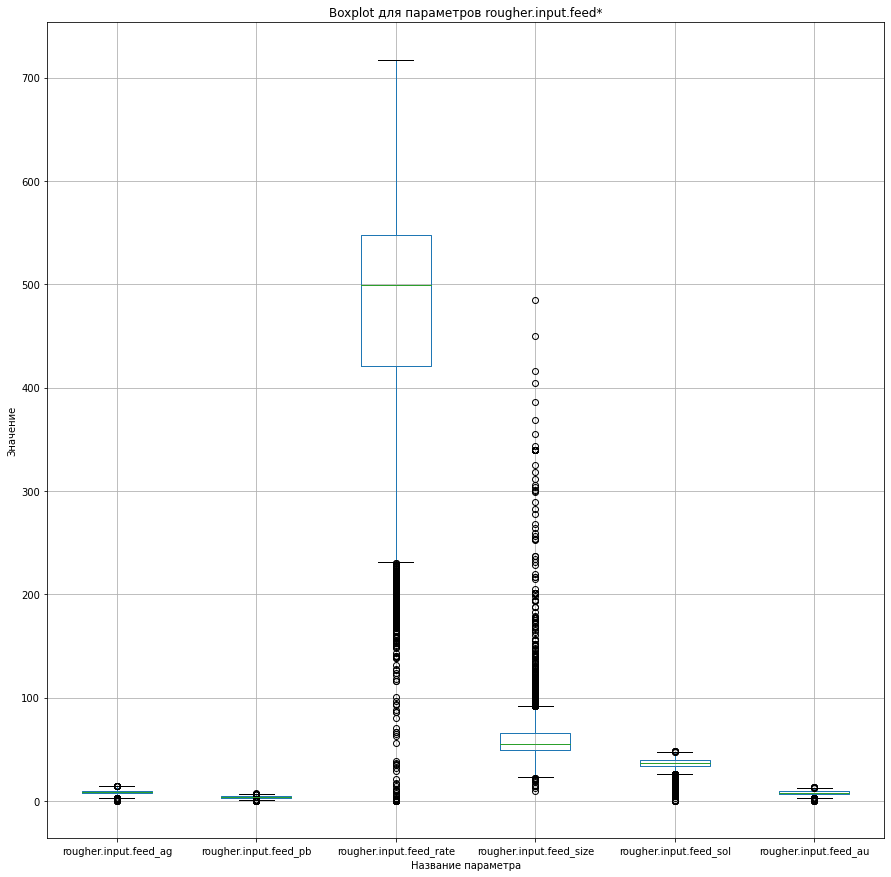

In [16]:
data_train[columns_input].filter(regex='rougher\.input\.feed').boxplot(figsize=(15,15));
plt.title('Boxplot для параметров rougher.input.feed*')
plt.xlabel('Название параметра')
plt.ylabel('Значение')
plt.show()

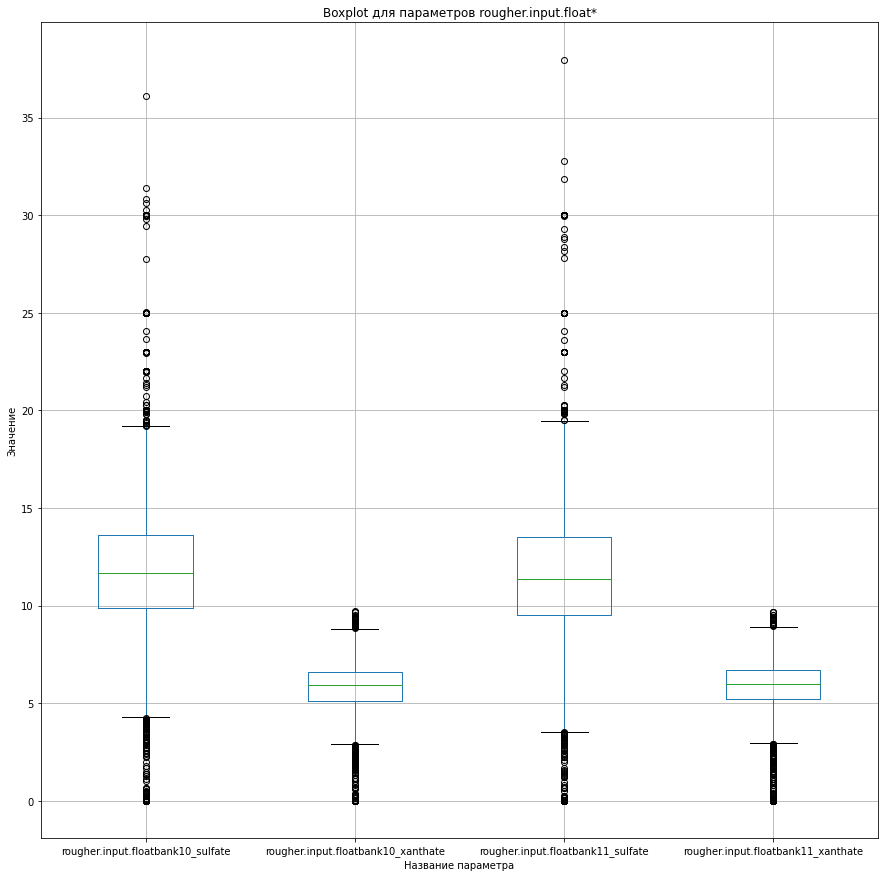

In [17]:
data_train[columns_input].filter(regex='rougher\.input\.float').boxplot(figsize=(15,15));
plt.title('Boxplot для параметров rougher.input.float*')
plt.xlabel('Название параметра')
plt.ylabel('Значение')
plt.show()

In [18]:
data_train[columns_input].filter(regex='rougher').isna().sum()/len(data_train)*100

rougher.input.feed_ag                 0.000000
rougher.input.feed_pb                 0.706764
rougher.input.feed_rate               0.056541
rougher.input.feed_size               1.017740
rougher.input.feed_sol                0.551276
rougher.input.feed_au                 0.000000
rougher.input.floatbank10_sulfate     0.204961
rougher.input.floatbank10_xanthate    0.056541
rougher.input.floatbank11_sulfate     0.254435
rougher.input.floatbank11_xanthate    3.024949
dtype: float64

 - feed_ag, feed_pb, floatbank... - параметры, отвечающие за концентрацию. Посмотрим, как они зависят от времени. Будем смотреть топ-3 по пропускам, остальных пропусков совсем мало, можно будет удалить. 

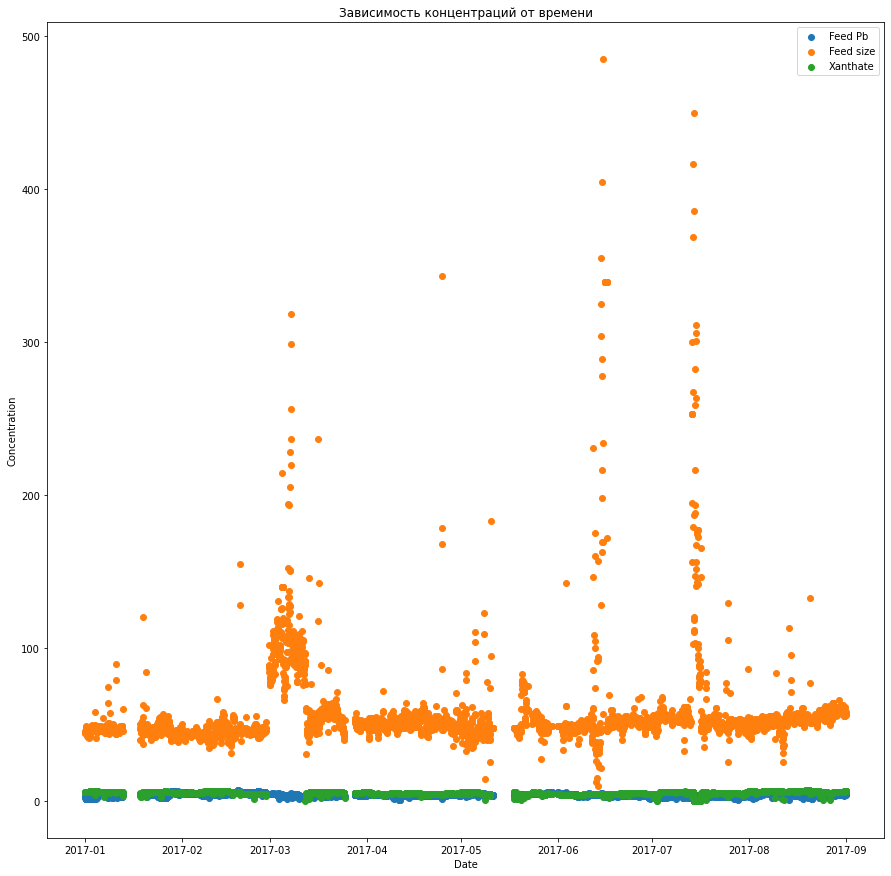

In [19]:
data_train['date'] = pd.to_datetime(data_train['date'])
data_train_slice = data_train[data_train['date'].dt.year == 2017]
#data_train_slice = data_train_slice[data_train_slice['date'].dt.month == 3]
plt.figure(figsize=(15, 15))
plt.scatter(data_train_slice['date'], data_train_slice['rougher.input.feed_pb'], label='Feed Pb')
plt.scatter(data_train_slice['date'], data_train_slice['rougher.input.feed_size'], label='Feed size')
plt.scatter(data_train_slice['date'], data_train_slice['rougher.input.floatbank11_xanthate'], label='Xanthate')
# add labels and legend
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()

# add a blank title
plt.title('Зависимость концентраций от времени')

# display the plot
plt.show()

- feed_pb, feed_size - можно заменить соседними значениями, если они не NaN
- xanthate - тут не очень понятно. Есть один большой провал в данных - то ли этой присадки не было, то ли она не учитывалась. В реальных условиях надо было бы по этому xanthate переговорить с кем-то. В учебной ситуации заменим медианой. 

In [20]:
data_train['rougher.input.feed_size'] = data_train['rougher.input.feed_size'].fillna(method='ffill')
data_train['rougher.input.feed_pb'] = data_train['rougher.input.feed_pb'].fillna(method='ffill')
data_train['rougher.input.floatbank11_xanthate'] = data_train['rougher.input.floatbank11_xanthate'].fillna(data_train['rougher.input.floatbank11_xanthate'].median())

- feed_rate изучим отдельно

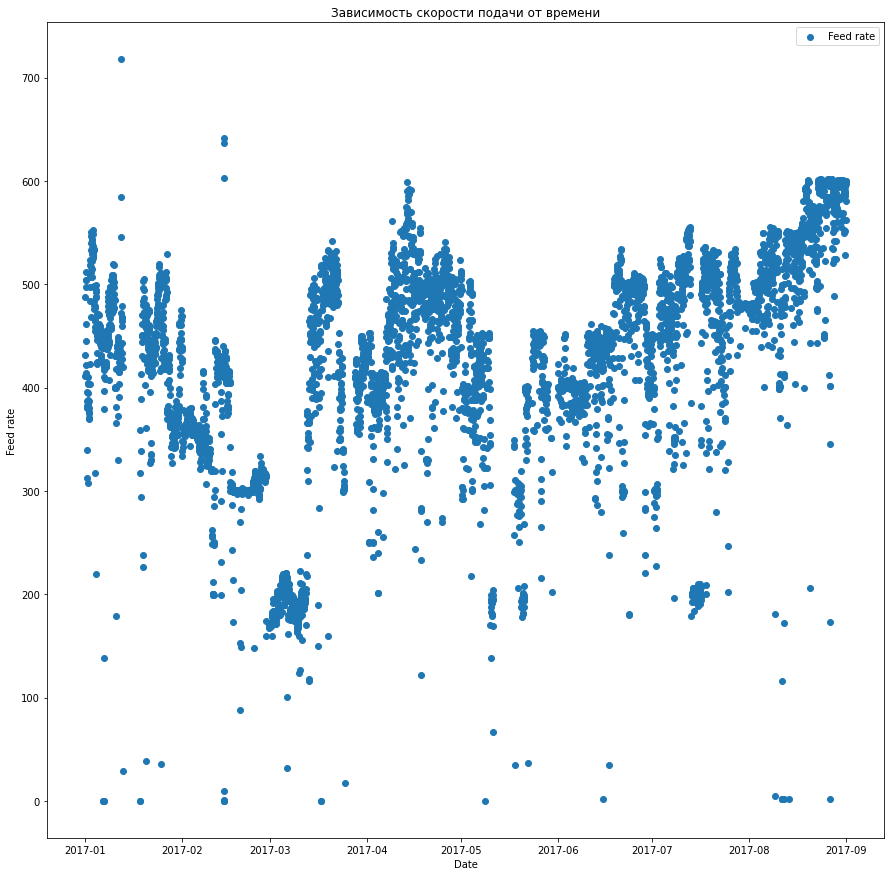

In [21]:
data_train['date'] = pd.to_datetime(data_train['date'])
data_train_slice = data_train[data_train['date'].dt.year == 2017]
#data_train_slice = data_train_slice[data_train_slice['date'].dt.month == 3]
plt.figure(figsize=(15, 15))
plt.scatter(data_train_slice['date'], data_train_slice['rougher.input.feed_rate'], label='Feed rate')
plt.xlabel('Date')
plt.ylabel('Feed rate')
plt.legend()

# add a blank title
plt.title('Зависимость скорости подачи от времени')

# display the plot
plt.show()

Разброс между значениями бывает приличный, параметр очень важный, пропусков в нем совсем мало. Удаляем. 

In [22]:
data_train.dropna(subset=['rougher.input.feed_rate'], inplace=True)
data_train.dropna(subset=['rougher.input.feed_sol'], inplace=True)
data_train.dropna(subset=['rougher.input.floatbank10_sulfate'], inplace=True)
data_train.dropna(subset=['rougher.input.floatbank10_xanthate'], inplace=True)
data_train.dropna(subset=['rougher.input.floatbank11_sulfate'], inplace=True)

In [23]:
data_train[columns_input].filter(regex='rougher').isna().sum()

rougher.input.feed_ag                 0
rougher.input.feed_pb                 0
rougher.input.feed_rate               0
rougher.input.feed_size               0
rougher.input.feed_sol                0
rougher.input.feed_au                 0
rougher.input.floatbank10_sulfate     0
rougher.input.floatbank10_xanthate    0
rougher.input.floatbank11_sulfate     0
rougher.input.floatbank11_xanthate    0
dtype: int64

In [24]:
data_train[columns_input].filter(regex='primary_cleaner').isna().sum()/len(data_train)*100

primary_cleaner.input.sulfate       0.028527
primary_cleaner.input.depressant    0.121238
primary_cleaner.input.feed_size     0.000000
primary_cleaner.input.xanthate      0.634717
dtype: float64

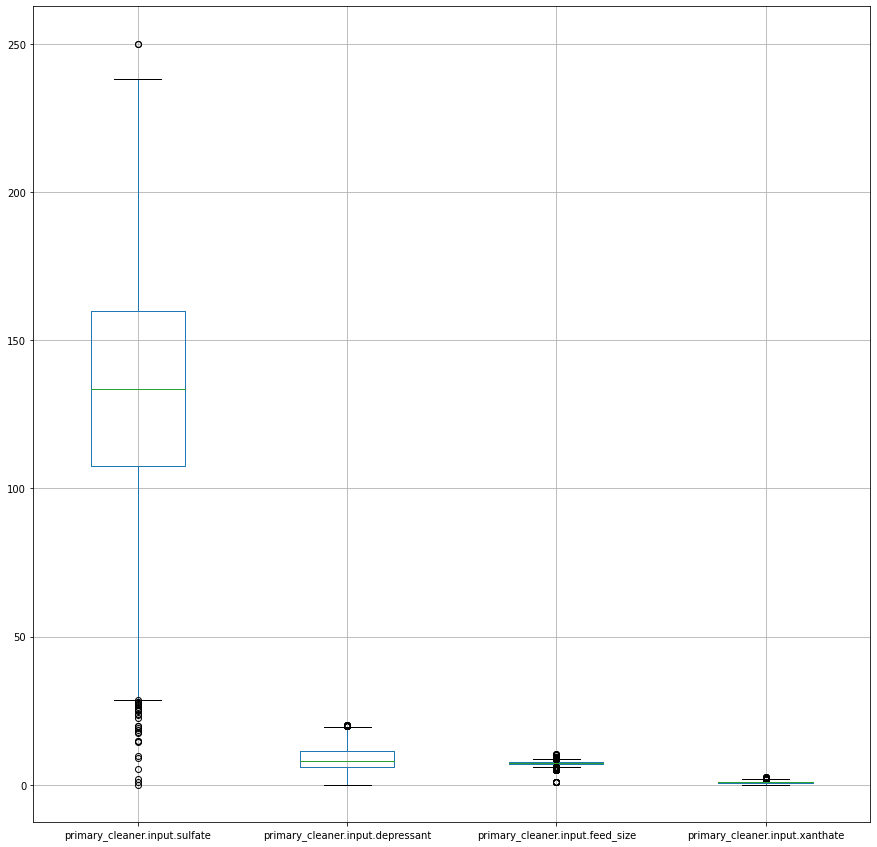

In [25]:
data_train[columns_input].filter(regex='primary_cleaner').boxplot(figsize=(15,15));

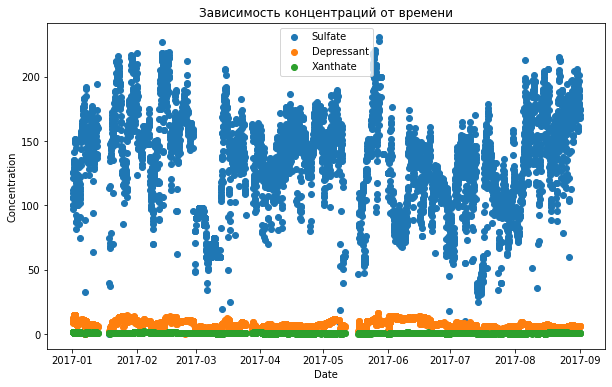

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(data_train_slice['date'], data_train_slice['primary_cleaner.input.sulfate'], label='Sulfate')
plt.scatter(data_train_slice['date'], data_train_slice['primary_cleaner.input.depressant'], label='Depressant')
plt.scatter(data_train_slice['date'], data_train_slice['primary_cleaner.input.xanthate'], label='Xanthate')

plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()

# add a blank title
plt.title('Зависимость концентраций от времени')

# display the plot
plt.show()

Заменим на соседние ненулевые.  

In [27]:
data_train['primary_cleaner.input.sulfate'] = data_train['primary_cleaner.input.sulfate'].fillna(method='ffill')
data_train['primary_cleaner.input.depressant'] = data_train['primary_cleaner.input.depressant'].fillna(method='ffill')
data_train['primary_cleaner.input.xanthate'] = data_train['primary_cleaner.input.xanthate'].fillna(method='ffill')

In [28]:
data_train[columns_input].filter(regex='primary_cleaner').isna().sum()

primary_cleaner.input.sulfate       0
primary_cleaner.input.depressant    0
primary_cleaner.input.feed_size     0
primary_cleaner.input.xanthate      0
dtype: int64

#### Предобработка state

In [29]:
columns_state = []
for col in data_train.columns:
    if 'state' in col:
        columns_state.append(col)
columns_state

['primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_d_air',
 'rougher.state.floatbank10_d_level',
 'rougher.state.floatbank10_e_air',
 'rougher.state.floatbank10_e_level',
 'rougher.state.floatbank10_f_air',
 'rougher.state.floatbank10_f_level',
 'secondary_cleaner.state.floatbank2_a_air',
 'secondary_cleaner.state.floatbank2_a_level',
 'secondary_cleaner.state.floatbank2_b_air',
 'secondary_cleaner.state.floatbank2_b_level',
 'secondary_cleaner.

In [30]:
data_train[columns_state].isna().sum()*100/len(data_train)

primary_cleaner.state.floatbank8_a_air        0.021395
primary_cleaner.state.floatbank8_a_level      0.000000
primary_cleaner.state.floatbank8_b_air        0.021395
primary_cleaner.state.floatbank8_b_level      0.000000
primary_cleaner.state.floatbank8_c_air        0.007132
primary_cleaner.state.floatbank8_c_level      0.000000
primary_cleaner.state.floatbank8_d_air        0.014263
primary_cleaner.state.floatbank8_d_level      0.000000
rougher.state.floatbank10_a_air               0.000000
rougher.state.floatbank10_a_level             0.000000
rougher.state.floatbank10_b_air               0.000000
rougher.state.floatbank10_b_level             0.000000
rougher.state.floatbank10_c_air               0.000000
rougher.state.floatbank10_c_level             0.000000
rougher.state.floatbank10_d_air               0.000000
rougher.state.floatbank10_d_level             0.000000
rougher.state.floatbank10_e_air               3.066610
rougher.state.floatbank10_e_level             0.000000
rougher.st

Пропущенные данные - только в параметре air. 

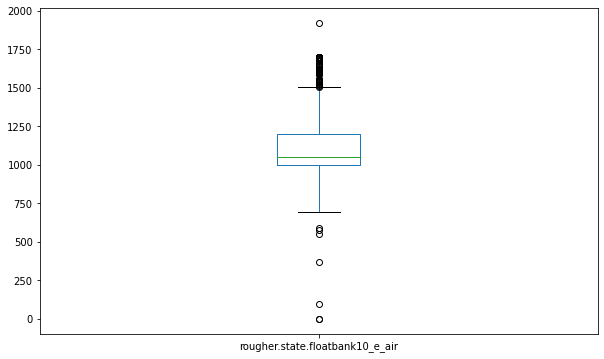

In [31]:
data_train['rougher.state.floatbank10_e_air'].plot.box(figsize=(10, 6));

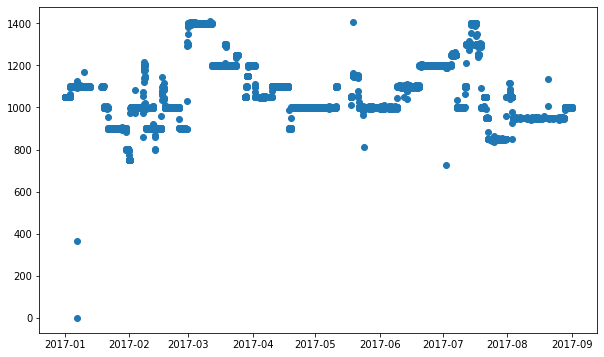

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(data_train_slice['date'], data_train_slice['rougher.state.floatbank10_e_air'], label='rougher.state.floatbank10_e_air');

Далеко не всегда соседние параметры близки. Учитывая, что пропущенных значений всего около 3 процентов, лучше их удалить.

In [33]:
data_train.dropna(subset=columns_state, inplace=True)

In [34]:
data_train[columns_state].isna().sum()

primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.state.floatbank10_a_air               0
rougher.state.floatbank10_a_level             0
rougher.state.floatbank10_b_air               0
rougher.state.floatbank10_b_level             0
rougher.state.floatbank10_c_air               0
rougher.state.floatbank10_c_level             0
rougher.state.floatbank10_d_air               0
rougher.state.floatbank10_d_level             0
rougher.state.floatbank10_e_air               0
rougher.state.floatbank10_e_level             0
rougher.state.floatbank10_f_air               0
rougher.state.floatbank10_f_level             0
secondary_cleaner.state.floatbank2_a_air

#### Предобработка output

In [35]:
columns_output = []
for col in data_train.columns:
    if 'output' in col:
        columns_output.append(col)
columns_output

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol',
 'secondary_cleaner.output.tail_au',
 'rougher.o

In [36]:
data_train[columns_output].isna().sum()*100/len(data_train)

final.output.concentrate_ag                0.007482
final.output.concentrate_pb                0.007482
final.output.concentrate_sol               1.503928
final.output.concentrate_au                0.000000
final.output.recovery                      0.000000
final.output.tail_ag                       0.000000
final.output.tail_pb                       0.748223
final.output.tail_sol                      0.022447
final.output.tail_au                       0.000000
primary_cleaner.output.concentrate_ag      0.000000
primary_cleaner.output.concentrate_pb      0.523756
primary_cleaner.output.concentrate_sol     1.698466
primary_cleaner.output.concentrate_au      0.000000
primary_cleaner.output.tail_ag             0.007482
primary_cleaner.output.tail_pb             0.112233
primary_cleaner.output.tail_sol            0.299289
primary_cleaner.output.tail_au             0.000000
rougher.output.concentrate_ag              0.000000
rougher.output.concentrate_pb              0.000000
rougher.outp

Ничего из output мы для машинного обучения не будем брать, потому что обязательно произойдет утечка признаков. Убедились, что в целевых параметрах - concentrat_au и tail_au - нет пропусков.

#### Предобработка calculations

In [37]:
columns_calculations = []
for col in data_train.columns:
    if 'calcul' in col:
        columns_calculations.append(col)
columns_calculations

['rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.recovery_calculated']

In [38]:
data_train[columns_calculations].isna().sum()

rougher.calculation.sulfate_to_au_concentrate         0
rougher.calculation.floatbank10_sulfate_to_au_feed    0
rougher.calculation.floatbank11_sulfate_to_au_feed    0
rougher.calculation.au_pb_ratio                       0
rougher.output.recovery_calculated                    0
dtype: int64

#### Обработаем признаки в тестовой выборке

In [39]:
pd.set_option('display.max_rows', None)
data_test.isna().sum()/len(data_train)*100

date                                          0.000000
primary_cleaner.input.sulfate                 0.029929
primary_cleaner.input.depressant              0.037411
primary_cleaner.input.feed_size               0.000000
primary_cleaner.input.xanthate                0.029929
primary_cleaner.state.floatbank8_a_air        0.000000
primary_cleaner.state.floatbank8_a_level      0.000000
primary_cleaner.state.floatbank8_b_air        0.000000
primary_cleaner.state.floatbank8_b_level      0.000000
primary_cleaner.state.floatbank8_c_air        0.000000
primary_cleaner.state.floatbank8_c_level      0.000000
primary_cleaner.state.floatbank8_d_air        0.000000
primary_cleaner.state.floatbank8_d_level      0.000000
rougher.input.feed_ag                         0.000000
rougher.input.feed_pb                         0.000000
rougher.input.feed_rate                       0.022447
rougher.input.feed_size                       0.007482
rougher.input.feed_sol                        0.157127
rougher.in

Пропусков в тестовой выборке меньше 1 процента. Удаляем. 

In [40]:
data_test = data_test.dropna()
data_test.isna().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

### Вывод по разделу
Проведена предобработка данных датасета data_train, данные готовы для анализа и построения модели.

## Анализ данных

### Изменение концентрации данных на различных этапах очистки

In [41]:
columns_output

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol',
 'secondary_cleaner.output.tail_au',
 'rougher.o

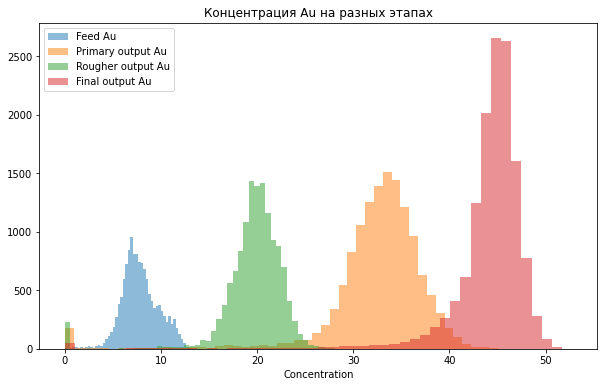

In [42]:
plt.figure(figsize=(10,6))
plt.hist(data_train['rougher.input.feed_au'], bins=50, label='Feed Au', alpha=0.5)
plt.hist(data_train['primary_cleaner.output.concentrate_au'], bins=50, label='Primary output Au', alpha=0.5)
plt.hist(data_train['rougher.output.concentrate_au'], bins=50, label='Rougher output Au', alpha=0.5)
plt.hist(data_train['final.output.concentrate_au'], bins=50, label='Final output Au', alpha=0.5)
plt.legend()
plt.xlabel('Concentration')
plt.title('Концентрация Au на разных этапах')
plt.show()

На всех этапах есть аномалии в районе 0. Надо удалить данные, в которых концентрации меньше 10. 

In [43]:
data_train = data_train[data_train['primary_cleaner.output.concentrate_au'] >= 10]
data_train = data_train[data_train['rougher.output.concentrate_au'] >= 10]
data_train = data_train[data_train['final.output.concentrate_au'] >= 10]

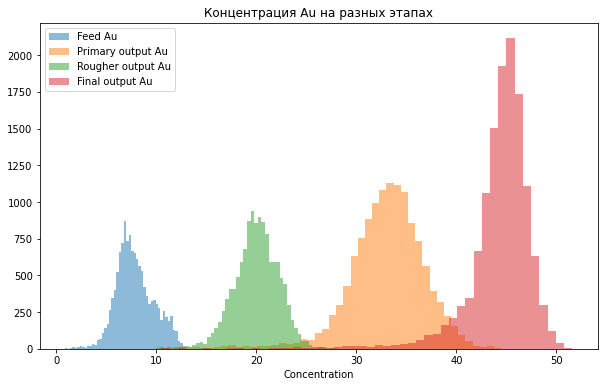

In [44]:
plt.figure(figsize=(10,6))
plt.hist(data_train['rougher.input.feed_au'], bins=50, label='Feed Au', alpha=0.5)
plt.hist(data_train['primary_cleaner.output.concentrate_au'], bins=50, label='Primary output Au', alpha=0.5)
plt.hist(data_train['rougher.output.concentrate_au'], bins=50, label='Rougher output Au', alpha=0.5)
plt.hist(data_train['final.output.concentrate_au'], bins=50, label='Final output Au', alpha=0.5)
plt.legend()
plt.xlabel('Concentration')
plt.title('Концентрация Au на разных этапах')
plt.show()

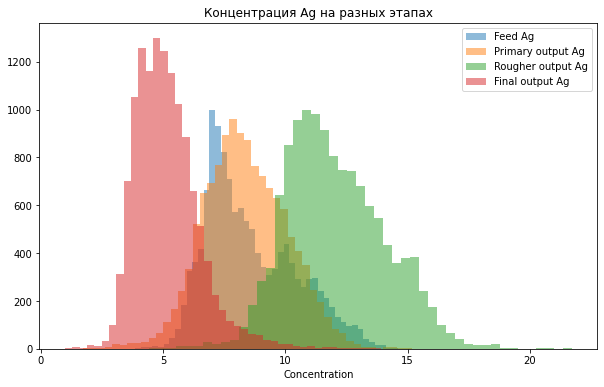

In [45]:
plt.figure(figsize=(10,6))
plt.hist(data_train['rougher.input.feed_ag'], bins=50, label='Feed Ag', alpha=0.5)
plt.hist(data_train['primary_cleaner.output.concentrate_ag'], bins=50, label='Primary output Ag', alpha=0.5)
plt.hist(data_train['rougher.output.concentrate_ag'], bins=50, label='Rougher output Ag', alpha=0.5)
plt.hist(data_train['final.output.concentrate_ag'], bins=50, label='Final output Ag', alpha=0.5)
plt.legend()
plt.xlabel('Concentration')
plt.title('Концентрация Ag на разных этапах')
plt.show()

Концентрация серебра в сырье распределена менее однородно, чем в золоте. На каждом цикле концентрация уменьшается. 

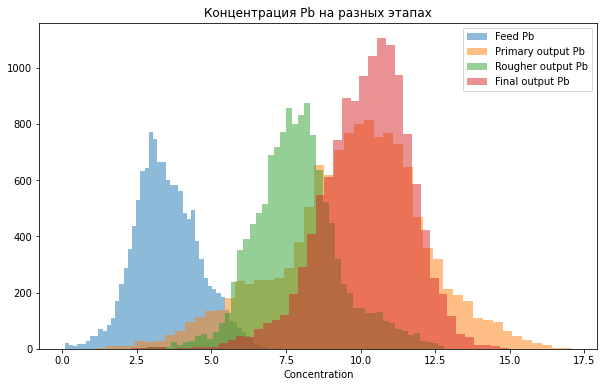

In [46]:
plt.figure(figsize=(10,6))
plt.hist(data_train['rougher.input.feed_pb'], bins=50, label='Feed Pb', alpha=0.5)
plt.hist(data_train['primary_cleaner.output.concentrate_pb'], bins=50, label='Primary output Pb', alpha=0.5)
plt.hist(data_train['rougher.output.concentrate_pb'], bins=50, label='Rougher output Pb', alpha=0.5)
plt.hist(data_train['final.output.concentrate_pb'], bins=50, label='Final output Pb', alpha=0.5)
plt.legend()
plt.xlabel('Concentration')
plt.title('Концентрация Pb на разных этапах')
plt.show()

Приключения концентрации свинца менее очевидны, но аномалий никаких не видно. 

Золота и свинца чем дальше по технологической цепочке, тем больше. А концентрация серебра, наоборот, уменьшается с каждым циклом очистки.

In [47]:
data_train[['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']].mean().sort_values(ascending=False)

final.output.concentrate_pb              10.211786
primary_cleaner.output.concentrate_pb     9.708389
rougher.output.concentrate_pb             7.867019
dtype: float64

### Распределения размеров гранул сырья на обучающей и тестовой выборках

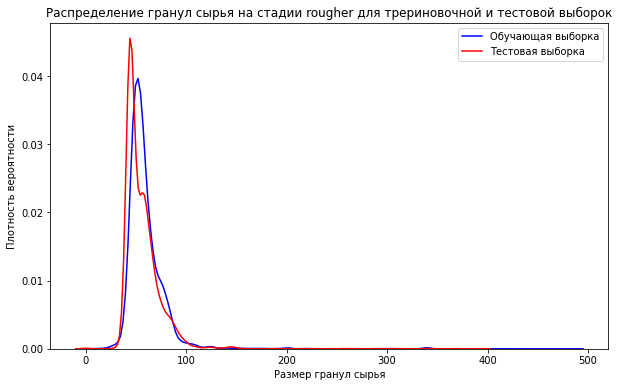

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(data_train['rougher.input.feed_size'], ax=ax, label='Обучающая выборка', color='blue')

sns.kdeplot(data_test['rougher.input.feed_size'], ax=ax, label='Тестовая выборка', color='red')

ax.set_title('Распределение гранул сырья на стадии rougher для трериновочной и тестовой выборок')
ax.set_xlabel('Размер гранул сырья')
ax.set_ylabel('Плотность вероятности')
ax.legend()

plt.show()

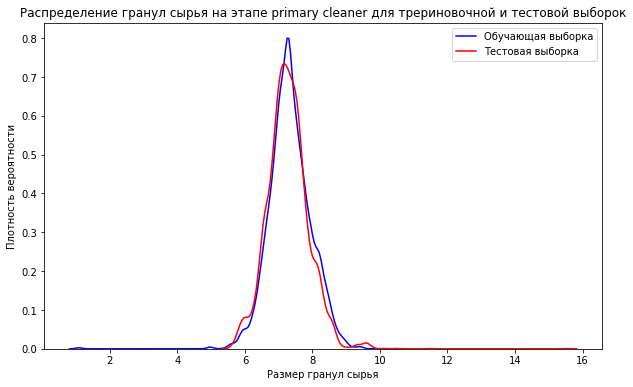

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(data_train['primary_cleaner.input.feed_size'], ax=ax, label='Обучающая выборка', color='blue')

sns.kdeplot(data_test['primary_cleaner.input.feed_size'], ax=ax, label='Тестовая выборка', color='red')

ax.set_title('Распределение гранул сырья на этапе primary cleaner для трериновочной и тестовой выборок')
ax.set_xlabel('Размер гранул сырья')
ax.set_ylabel('Плотность вероятности')
ax.legend()

plt.show()

### Cуммарная концентрация всех веществ на разных стадиях

In [50]:
data_train['rougher.calculation.input_concentrate'] = (data_train['rougher.input.feed_au'] + 
                                                       data_train['rougher.input.feed_ag'] +
                                                       data_train['rougher.input.feed_pb'] + 
                                                       data_train['rougher.input.feed_sol'])

rougher_output_concentrate_cols = [col for col in data_train.columns if 'rougher.output.concentrate_' in col]
data_train['rougher.calculation.output_concentrate'] = data_train[rougher_output_concentrate_cols].sum(axis=1)

final_output_concentrate_cols = [col for col in data_train.columns if 'final.output.concentrate_' in col]
data_train['final.calculation.output_concentrate'] = data_train[final_output_concentrate_cols].sum(axis=1)


In [51]:
print('Средняя концентрация веществ в сырье:', data_train['rougher.calculation.input_concentrate'].mean())
print('Средняя концентрация веществ в черновом концентрате:', data_train['rougher.calculation.output_concentrate'].mean())
print('Средняя концентрация веществ в финальном концентрате:', data_train['final.calculation.output_concentrate'].mean())

Средняя концентрация веществ в сырье: 56.27804802410525
Средняя концентрация веществ в черновом концентрате: 68.86157750204784
Средняя концентрация веществ в финальном концентрате: 68.85732891292139


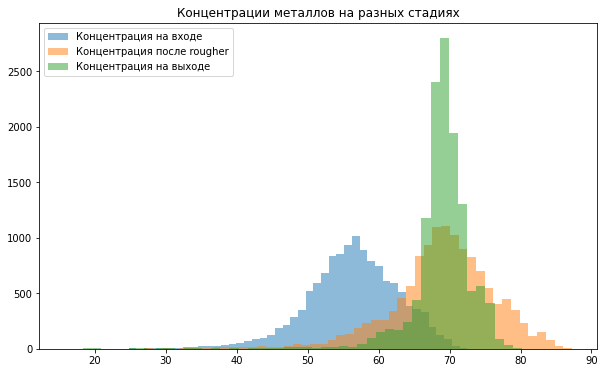

In [52]:
plt.figure(figsize=(10,6))
plt.hist(data_train['rougher.calculation.input_concentrate'], bins=50, label='Концентрация на входе', alpha=0.5)
plt.hist(data_train['rougher.calculation.output_concentrate'], bins=50, label='Концентрация после rougher', alpha=0.5)
plt.hist(data_train['final.calculation.output_concentrate'], bins=50, label='Концентрация на выходе', alpha=0.5)
plt.legend()
plt.title('Концентрации металлов на разных стадиях')
plt.show()

Концентрация веществ в сырье меньше, чем в концентратах. 

## Вывод по разделу

Общая онцентрация веществ в сырье меньше, чем в концентратах. Концентрация золота по мере прохождения технологической цепочки последовательно растет. Обнаружены и устранены аномалии в данных по концентрации золота. Исследование распределение размеров гранул сырья не выявило аномалий. 

## Моделирование

### Функция для вычисления итоговой sMAPE

In [1]:
def get_smape(target, predictions):
    smape = 0
    for i in range(len(target)):
        smape += 2 * abs(target.iloc[i] - predictions[i]) / (abs(target.iloc[i]) + abs(predictions[i]))
    smape = 100 * smape / len(target)
    return smape

def get_total_smape(rougher, final):
    total_smape = 0.25*rougher + 0.75*final
    return total_smape

### Применяем модели

#### Выделим параметры и целевые параметры

Выделим несколько возможных вариантов наборов параметров features

In [54]:
features = data_train.filter(regex='(rougher\.input\.feed)')
print('features', len(features))
target_rougher = data_train['rougher.output.recovery']
print('target_rougher', len(target_rougher))
target_final = data_train['final.output.recovery']
print('target_final', len(target_final))

features 12788
target_rougher 12788
target_final 12788


In [55]:
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

#### Кросс-валидация

Напишем функцию, которая для заданного датафрейма, модели, features, target_rougher и target_final посчитает показатель sMAPE на кросс-валидации. 

In [56]:
def crossvalid_score(model, features, target_rougher, target_final):
    
    scorer = make_scorer(get_smape, greater_is_better=False)

    # Cross-validate for target_rougher
    rougher_scores = cross_val_score(model, features, target_rougher, cv=5, scoring=scorer)

    # Cross-validate for target_final
    final_scores = cross_val_score(model, features, target_final, cv=5, scoring=scorer)

    # Calculate total smape
    total_smape = get_total_smape(rougher_scores.mean(), final_scores.mean())
    
    print(-total_smape)
    
    return -total_smape

#### Применим функцию для моделей регрессии в библиотеке sklearn

In [57]:
%%time
model = LinearRegression()
linear_regression_score = crossvalid_score(model, features, target_rougher, target_final)

8.402377669766217
CPU times: user 1.03 s, sys: 894 ms, total: 1.92 s
Wall time: 1.87 s


In [58]:
%%time
model = GradientBoostingRegressor(random_state=12345)
GradientBoostingRegressor_score = crossvalid_score(model, features, target_rougher, target_final)

7.895848068403517
CPU times: user 22.3 s, sys: 6.15 ms, total: 22.3 s
Wall time: 22.5 s


In [59]:
%%time
model = SGDRegressor(random_state=12345)
SGDRegressor_score = crossvalid_score(model, features, target_rougher, target_final)

8.398939810880147
CPU times: user 1.12 s, sys: 824 ms, total: 1.95 s
Wall time: 1.95 s


In [60]:
%%time
model = SVR()
SVR_score = crossvalid_score(model, features, target_rougher, target_final)

7.929982936482739
CPU times: user 54.3 s, sys: 1.37 s, total: 55.7 s
Wall time: 55.7 s


In [61]:
%%time
model = ElasticNet(random_state=12345)
ElasticNet_score = crossvalid_score(model, features, target_rougher, target_final)

8.293532562052011
CPU times: user 1.29 s, sys: 1.47 s, total: 2.76 s
Wall time: 2.76 s


In [62]:
%%time
model = BayesianRidge()
BayesianRidge_score = crossvalid_score(model, features, target_rougher, target_final)

8.39824960336761
CPU times: user 1.42 s, sys: 1.25 s, total: 2.67 s
Wall time: 2.69 s


Лучший результат получен для модели ElasticNet. Займемся оптимизацией ее гиперпараметров.

In [63]:
model = ElasticNet(random_state=12345)

scorer =  make_scorer(get_smape, greater_is_better=False)

param_grid = {'alpha': [0.1, 1, 10],
              'l1_ratio': [0.1, 0.5, 0.9]}

grid_search_r = GridSearchCV(model, param_grid, cv=5, scoring=scorer)

grid_search_r.fit(features, target_rougher)

print("Гиперпараметры для target_rougher: ", grid_search_r.best_params_)
print('sMAPE для target_rougher: ', -grid_search_r.best_score_)

grid_search_f.fit(features, target_final)
print("Гиперпараметры для target_final: ", grid_search_f.best_params_)
print('sMAPE для target_final: ', -grid_search_f.best_score_)

Гиперпараметры для target_rougher:  {'alpha': 0.1, 'l1_ratio': 0.1}
sMAPE для target_rougher:  6.4619456873266525
Гиперпараметры для target_final:  {'alpha': 1, 'l1_ratio': 0.1}
sMAPE для target_final:  8.798041670842162


In [64]:
get_total_smape(-grid_search_r.best_score_, -grid_search_f.best_score_)

8.214017674963285

### Применим к тестовому датасету

#### Применяем оптимизированную модель для получения предсказаний

In [64]:
features_test = data_test.filter(regex='(rougher\.input\.feed)')
features_test = scaler.transform(features_test)

In [65]:
features_test.shape

(5229, 6)

In [66]:
model = ElasticNet(random_state=12345, alpha=0.1, l1_ratio=0.1)
model.fit(features, target_rougher)
predictions_rougher_test = model.predict(features_test)
predictions_rougher_test

array([95.00583757, 94.33692922, 94.98338945, ..., 90.80093873,
       91.10878899, 89.85263586])

In [67]:
model = ElasticNet(random_state=12345, alpha=1, l1_ratio=0.5)
model.fit(features, target_final)
predictions_final_test = model.predict(features_test)
predictions_final_test

array([73.40015024, 73.06248169, 73.46905018, ..., 70.99770705,
       71.06274492, 70.46675849])

#### Считаем sMAPE

In [68]:
# Получим целевые значения из полного датасета
data_test['date'] = pd.to_datetime(data_test['date'])
data_full['date'] = pd.to_datetime(data_full['date'])
data_test_target = pd.merge(data_test, data_full[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date')
#data_test_target.head(10)

In [69]:
# Выделим ответы
target_test_rougher = data_test_target['rougher.output.recovery']
target_test_final = data_test_target['final.output.recovery']

print('features_test', len(features_test))
print('target_test_rougher', len(target_test_rougher))
print('target_test_final', len(target_test_final))

features_test 5229
target_test_rougher 5229
target_test_final 5229


In [78]:
predictions_rougher_test = pd.Series(predictions_rougher_test)
smape_rougher_test = get_smape(target_test_rougher, predictions_rougher_test)
print('Метрика для rougher', smape_rougher_test)

Метрика для rougher 7.596738954044708


In [79]:
predictions_final_test = pd.Series(predictions_final_test)
smape_final_test = get_smape(target_test_final, predictions_final_test)
print('Метрика для final', smape_final_test)

Метрика для final 8.542063247310884


In [80]:
total_smape = get_total_smape(smape_rougher_test, smape_final_test)
print('Общяя метрика', total_smape)

Общяя метрика 8.30573217399434


#### Предсказание средним

In [73]:
prediction_rougher_test_mean = pd.Series(target_rougher.mean(), index=predictions_rougher_test.index)

In [74]:
prediction_final_test_mean = pd.Series(target_final.mean(), index=predictions_rougher_test.index)

In [85]:
mean_rougher_smape = get_smape(target_test_rougher, prediction_rougher_test_mean)
mean_rougher_smape

8.987808242389166

In [86]:
mean_final_smape = get_smape(target_test_final, prediction_final_test_mean)
mean_final_smape

9.620524511417443

In [87]:
total_smape_rougher = get_total_smape(mean_rougher_smape, mean_final_smape)
total_smape_rougher

9.462345444160373

In [ ]:
print('Эффективность предсказания повышается на', total_smape_rougher - )

# Общий вывод

Исследованы модели, которые на основе качества входного сырья определяет эффективность очистки золота. Модель ElasticNet из библиотеки sklearn позволяет получать показатели с низкой метрикой ошибки при сравнительно быстрой работе. Для данной модели проведена оптимизаци гиперпараметров, получены оптимальные гиперпараметры для предсказания эффективности очистки золота на разничных этапах. Метрика ошибки для предсказаний, полученных на тестовой выборке для оптимизированной модели, оказалась на 1,5 процента ниже, чем метрика для референсной модели, предсказывающей средним значением. 